<a href="https://colab.research.google.com/github/FatemeFarhang/data-science/blob/main/Task_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download dataset and saved models (only first run)

In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# download dataset
!kaggle datasets download -d kazanova/sentiment140

 90% 73.0M/80.9M [00:03<00:00, 26.2MB/s]
100% 80.9M/80.9M [00:03<00:00, 25.0MB/s]


In [ ]:
# Unzip data file
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# download saved model
!kaggle kernels output paoloripamonti/twitter-sentiment-analysis

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: model.w2v


### Required Libraries (every run)

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# # Scikit-learn
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from sklearn.manifold import TSNE
# from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
from datetime import datetime


### Defaults

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

## Load dataset

In [ ]:
path_saved_files = 'drive/MyDrive/prav_tests'
dataset_path = path_saved_files +  '/training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS, usecols =[0,2,4,5])
df = df.sample(frac = 0.01 , random_state = 0)

Open file: drive/MyDrive/prav_tests/training.1600000.processed.noemoticon.csv


In [ ]:
pd.set_option("max_colwidth", 200)
df.head(6)

,target,date,user,text
557138,0,Wed Jun 17 02:14:00 PDT 2009,einmensch,wants to compete! i want hard competition! i want to rally. i want to feel the power coming out of the engine! i want to compete
349381,0,Wed Jun 03 07:56:34 PDT 2009,keithmorrison,It seems we are stuck on the ground in Amarillo. They have put a ground stop for all flights leaving for Denver. Said updates in an hour
182051,0,Fri May 29 18:52:13 PDT 2009,PunkieDory,where the f are my pinking shears? rarararrrarararr...babyproofing while cutting stuff makes me stick shears random places &amp; forget them
571236,0,Wed Jun 17 09:32:48 PDT 2009,DYkEY_tYPE,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER MY fREE tiME..gRRR!
1339637,4,Wed Jun 03 10:25:27 PDT 2009,BlueSmartiies,@ reply me pls
758738,0,Tue Jun 23 08:29:12 PDT 2009,abtony,@bharathy_99: Jazz in India is just Honda strategy to prove they can make affordable cars for the working class. It still doesn't fit me.


# First Metric | Average Interactions per post

In [91]:
%%time
df_user = pd.DataFrame(df.user.unique(),columns=['user_name'])

# no. of posts
df_user['#posts'] = [len(df[df['user']== i]) for i in df_user.user_name]

# no. of retweets
df_user['#retweets'] = 0
for user in df_user['user_name']:
    list_of_tweets = df[df['user'] == user]['text']
    retweets = len(df.loc[df['text'].isin(list_of_tweets)])
    if retweets != len(list_of_tweets):
        df_user.loc[df_user.user_name == user,'#retweets']= retweets - len(list_of_tweets)

CPU times: user 1min 52s, sys: 1.33 s, total: 1min 53s
Wall time: 1min 52s


The dataset didn't include likes or comments, so the only interaction is by retweeting.

In [94]:
df_user['#retweets'].unique()

array([0, 1, 3])

In [92]:
# compute metric
df_user['avg_interaction'] = df_user['#retweets']/df_user['#posts']
df_user.iloc[14:20]

,user_name,#posts,#retweets,avg_interaction
14,BrunaBenne,1,0,0.0
15,widyatarina,2,0,0.0
16,JoeRialiS,1,0,0.0
17,swaqqsoosiQk,1,0,0.0
18,Justasimplegirl,2,0,0.0
19,carinayeyy,1,0,0.0


# Second Metric | Passion Point

In [75]:
# no. of positive posts
df_user['#positive_posts'] = [len(df.loc[(df['user']== i) & (df['target'] == 4)]) for i in df_user.user_name]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9132efd610>]],
      dtype=object)

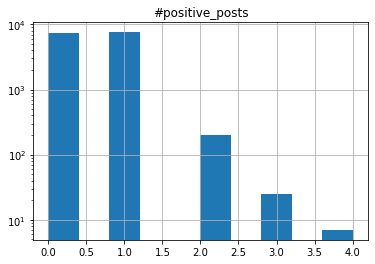

In [76]:
df_user.hist(['#positive_posts'], log=True)

In [ ]:
# quantile?
# if we find quantile we can find ranking and then passion point of users

# Third Metric | Content Creation

In order to find the number of positine words in tweets, it's helpful to find the word similarities to positive words in tweets.

## Pre-Process dataset

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 59.8 s, sys: 288 ms, total: 1min
Wall time: 1min


## Word2Vec

In [ ]:
%%time
documents = [_text.split() for _text in df.text] 

CPU times: user 4.44 s, sys: 723 ms, total: 5.17 s
Wall time: 5.16 s


In [ ]:
#load the model
w2v_model = gensim.models.word2vec.Word2Vec.load(path_saved_files + "/model.w2v")

2022-03-17 17:41:26,173 : INFO : loading Word2Vec object from drive/MyDrive/prav_tests/model.w2v
2022-03-17 17:41:27,951 : INFO : loading wv recursively from drive/MyDrive/prav_tests/model.w2v.wv.* with mmap=None
2022-03-17 17:41:27,954 : INFO : setting ignored attribute vectors_norm to None
2022-03-17 17:41:27,956 : INFO : loading vocabulary recursively from drive/MyDrive/prav_tests/model.w2v.vocabulary.* with mmap=None
2022-03-17 17:41:27,958 : INFO : loading trainables recursively from drive/MyDrive/prav_tests/model.w2v.trainables.* with mmap=None
2022-03-17 17:41:27,965 : INFO : setting ignored attribute cum_table to None
2022-03-17 17:41:27,969 : INFO : loaded drive/MyDrive/prav_tests/model.w2v


In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
w2v_model.wv.most_similar("love")

[('luv', 0.5732780694961548),
 ('loves', 0.5623787045478821),
 ('loved', 0.5373271703720093),
 ('amazing', 0.5026600360870361),
 ('adore', 0.4942743480205536),
 ('looove', 0.47235167026519775),
 ('awesome', 0.4598265290260315),
 ('lovee', 0.45823752880096436),
 ('loveee', 0.4531649351119995),
 ('loooove', 0.44260522723197937)]